# Build a LLM-powered Chatbot in LangGraph

LangGraph is not just a framework to create static graphs. We already know that it can be used for building stateful, agentic applications using LLMs.

We'll now create a simple LLM-powered chatbot using LangGraph. This chatbot will respond directly to user messages.

![](https://i.imgur.com/heeggTe.png)

In [7]:
!pip install langchain==0.3.27 langchain-openai==0.3.29 langgraph==0.6.5 --quiet

## Enter Open AI API Key & Setup Environment Variables

In [8]:
from getpass import getpass
import os

OPENAI_KEY = getpass('Enter Open AI API Key: ')
os.environ['OPENAI_API_KEY'] = OPENAI_KEY

Enter Open AI API Key: ··········


## State

First, define the [State](https://langchain-ai.github.io/langgraph/concepts/low_level/#state) of the graph.

The State schema serves as the input schema for all Nodes and Edges in the graph.

Let's use the `TypedDict` class from python's `typing` module as our schema, which provides type hints for the keys.

In [9]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

## Create the Nodes, Edges and Graph

In [10]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

def chatbot_node(state: State):
    # get the current state (which is basically the input user prompt)
    state = state['messages']
    llm_response = llm.invoke(state)
    return {"messages": [llm_response]} # appending llm_response to messages key

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot_node)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

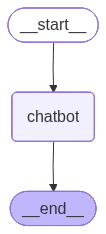

In [11]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
response = graph.invoke({"messages": "Explain Agentic AI in 2 bullet points"})
response

{'messages': [HumanMessage(content='Explain Agentic AI in 2 bullet points', additional_kwargs={}, response_metadata={}, id='b689fc5f-a63f-4f8f-ad4d-20d57c4cc021'),
  AIMessage(content='- **Definition**: Agentic AI refers to artificial intelligence systems that possess the ability to act autonomously, make decisions, and perform tasks in a way that mimics human agency, often adapting to new information and environments without direct human intervention.\n\n- **Applications and Implications**: These systems can be utilized in various fields such as robotics, autonomous vehicles, and personal assistants, raising important ethical considerations regarding accountability, safety, and the potential impact on employment and decision-making processes.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 96, 'prompt_tokens': 16, 'total_tokens': 112, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 

In [13]:
print(response['messages'][-1].content)

- **Definition**: Agentic AI refers to artificial intelligence systems that possess the ability to act autonomously, make decisions, and perform tasks in a way that mimics human agency, often adapting to new information and environments without direct human intervention.

- **Applications and Implications**: These systems can be utilized in various fields such as robotics, autonomous vehicles, and personal assistants, raising important ethical considerations regarding accountability, safety, and the potential impact on employment and decision-making processes.


In [14]:
from IPython.display import display_markdown

display_markdown(response['messages'][-1].content, raw=True)

- **Definition**: Agentic AI refers to artificial intelligence systems that possess the ability to act autonomously, make decisions, and perform tasks in a way that mimics human agency, often adapting to new information and environments without direct human intervention.

- **Applications and Implications**: These systems can be utilized in various fields such as robotics, autonomous vehicles, and personal assistants, raising important ethical considerations regarding accountability, safety, and the potential impact on employment and decision-making processes.

## Invoking vs. Streaming in LangGraph

In [15]:
response = graph.invoke({"messages": "Explain AI in 1 line"})
print(response['messages'][-1].content)

AI, or artificial intelligence, refers to the simulation of human intelligence in machines that are programmed to think, learn, and make decisions.


In [16]:
response = graph.invoke({"messages": "What did we discuss so far?"})
print(response['messages'][-1].content)

I don't have access to previous conversations or any context from earlier interactions. Each session is treated independently. If you have specific topics or questions in mind, feel free to share, and I'll do my best to assist you!


In [18]:
for event in graph.stream({"messages": "Explain AI in 1 line"},
                          stream_mode='values'):
    print(event['messages'])
    print()

[HumanMessage(content='Explain AI in 1 line', additional_kwargs={}, response_metadata={}, id='c27d8413-f006-4896-9b37-57fcf7702df7')]

[HumanMessage(content='Explain AI in 1 line', additional_kwargs={}, response_metadata={}, id='c27d8413-f006-4896-9b37-57fcf7702df7'), AIMessage(content='AI, or artificial intelligence, is the simulation of human intelligence processes by machines, particularly computer systems, enabling them to learn, reason, and make decisions.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 13, 'total_tokens': 44, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CfdynRXW2vtBFbjJBHdWxYpiBqEeg', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs